## Data Loader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
% cd 'drive/My Drive/project/'
% ls

/content/drive/My Drive/project
EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy              y_test.npy


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.4.1


In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769

In [5]:
from keras.utils import to_categorical
y_train_valid = keras.utils.to_categorical(y_train_valid)
y_test = keras.utils.to_categorical(y_test)

In [6]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Data Preprocessing

In [7]:
from scipy.signal import savgol_filter

def add_gaussian(X, mean=0, std=0.3):
    return X + np.random.normal(loc=mean, scale=std, size=X.shape)

def filtering(X):
    return savgol_filter(X,11,3)

In [8]:
X_train_gaussian = add_gaussian(X_train_valid, std=2)
X_train_filtered = savgol_filter(X_train_valid,11,3)

X_train_aug = np.concatenate((X_train_valid,X_train_gaussian,X_train_filtered), axis=0)
y_train_aug =  np.concatenate((y_train_valid,y_train_valid,y_train_valid), axis=0)
#print(X_train_aug.shape,y_train_aug.shape)

In [9]:
def plot_channel(data):
  plt.figure(figsize=(20,10))

  avg = np.mean(data, axis=0)
  name = []
  i = 0
  for channel in avg:
      plt.plot(channel)
      i += 1
      name.append('channel: ' + str(i))
     
  plt.legend(name)
  plt.show()


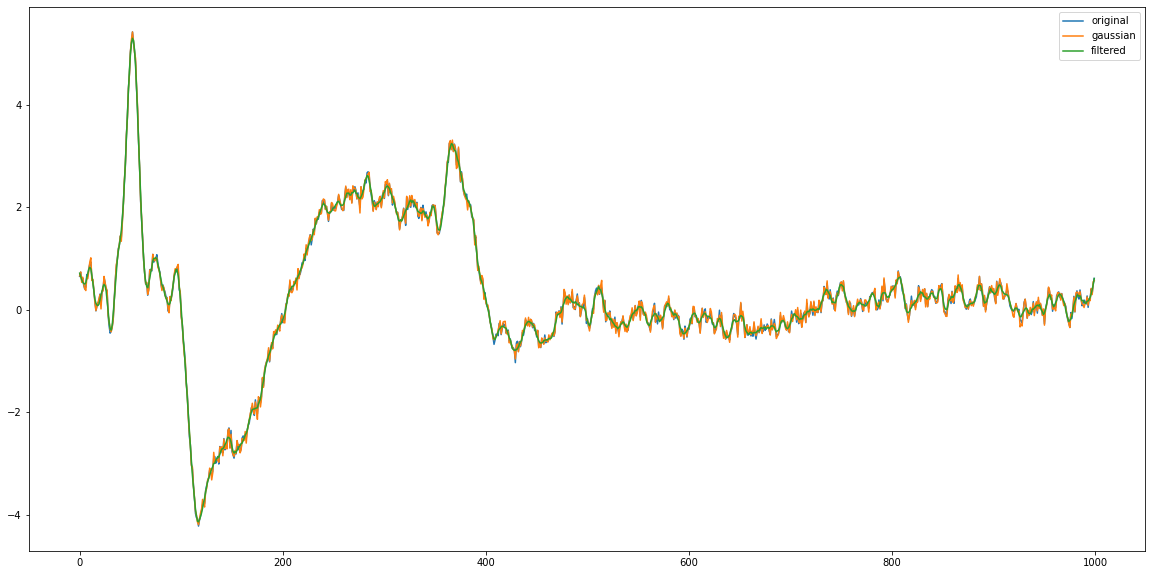

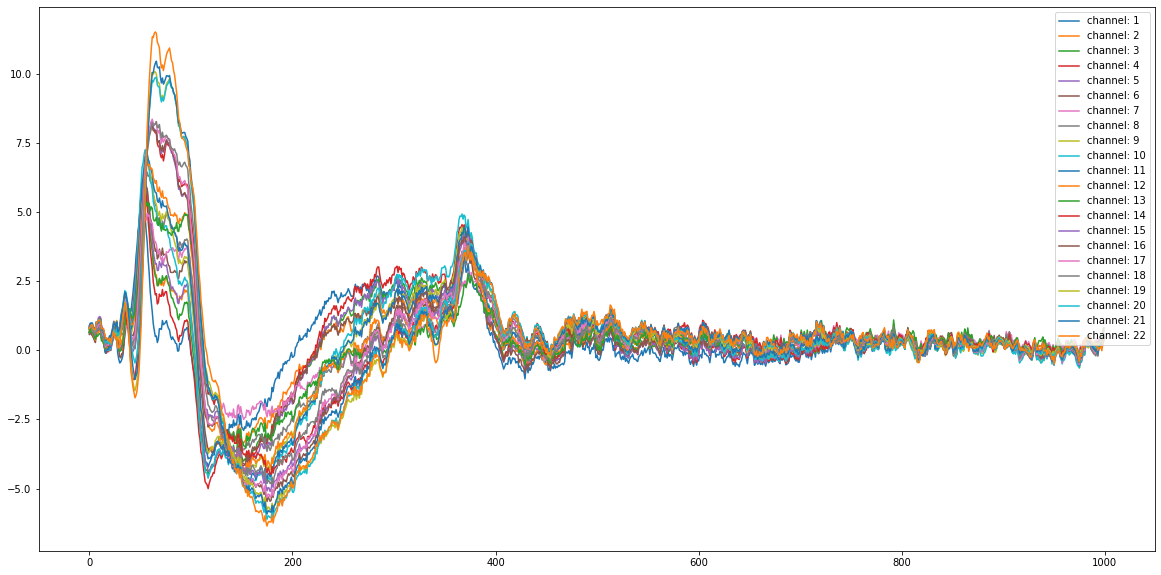

In [10]:
plt.figure(figsize=(20,10))
plt.plot((np.mean(X_train_valid,axis=0))[0], label="original")
plt.plot((np.mean(X_train_gaussian,axis=0))[0], label="gaussian")
plt.plot((np.mean(X_train_filtered,axis=0))[0], label="filtered")
plt.legend()
plt.show()
plot_channel(X_train_valid)
#plot_channel(X_train_gaussian)
#plot_channel(X_train_filtered)

In [168]:
# TA's method

def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

(8460, 22, 250)
(2115, 16)
(1772, 22, 250)
(443, 16)


## Train

In [11]:
from keras.initializers import lecun_uniform
def train(model_type = None, sub_idx=None, time_period=1000, data=None, num_epoch=20, num_batch=100, plot=True):
    # different period of time
    X_train_ = data['X_train'][:, :, :time_period]
    X_test_ = data['X_test'][:, :, :time_period]
    y_train_ = data['y_train']
    y_test_ = data['y_test']

    # single subject dataset
    if sub_idx is not None:
        X_train_ = X_train_[np.where(person_train_valid == sub_idx)[0]]
        y_train_ = y_train_[np.where(person_train_valid == sub_idx)[0]]
        X_test_ = X_test_[np.where(person_test == sub_idx)[0]]
        y_test_ = y_test_[np.where(person_test == sub_idx)[0]]

    # split into train and validation set
    perm = np.random.permutation(X_train_.shape[0])
    numTrain = int(0.8*X_train_.shape[0])
    Xtrain = X_train_[perm[0:numTrain]]
    ytrain = y_train_[perm[0:numTrain]]
    Xval = X_train_[perm[numTrain: ]]
    yval = y_train_[perm[numTrain: ]]

    lecun = lecun_uniform()
    model = model_type(lecun, time_period)

    history = model.fit(Xtrain, ytrain, epochs=num_epoch, batch_size=num_batch, validation_data=(Xval, yval), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train_, y_train_)
    test_score = model.evaluate(X_test_, y_test_)

    if plot:
      print(model.summary())

      # Plot training & validation accuracy values
      plt.plot(history.history['categorical_accuracy'])
      plt.plot(history.history['val_categorical_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

    return train_score[1]*100, test_score[1]*100

## Models

In [12]:
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape
from keras.regularizers import L1L2

### cnn1

In [76]:
# huanhua
def cnn1(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(16, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(16, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(8, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(8, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool2D((1, 4)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

Epoch 1/50
51/51 [==============================] - 2s 29ms/step - loss: 2.5005 - categorical_accuracy: 0.2291 - val_loss: 1.5079 - val_categorical_accuracy: 0.2553
Epoch 2/50
51/51 [==============================] - 1s 23ms/step - loss: 1.7357 - categorical_accuracy: 0.2404 - val_loss: 1.4040 - val_categorical_accuracy: 0.2656
Epoch 3/50
51/51 [==============================] - 1s 23ms/step - loss: 1.5959 - categorical_accuracy: 0.2578 - val_loss: 1.3953 - val_categorical_accuracy: 0.2774
Epoch 4/50
51/51 [==============================] - 1s 23ms/step - loss: 1.5222 - categorical_accuracy: 0.2656 - val_loss: 1.3712 - val_categorical_accuracy: 0.3042
Epoch 5/50
51/51 [==============================] - 1s 23ms/step - loss: 1.4808 - categorical_accuracy: 0.2667 - val_loss: 1.3756 - val_categorical_accuracy: 0.2987
Epoch 6/50
51/51 [==============================] - 1s 23ms/step - loss: 1.4504 - categorical_accuracy: 0.2715 - val_loss: 1.3715 - val_categorical_accuracy: 0.2994
Epoch 7/50

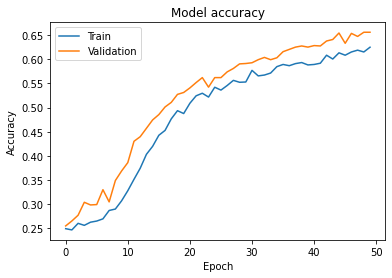

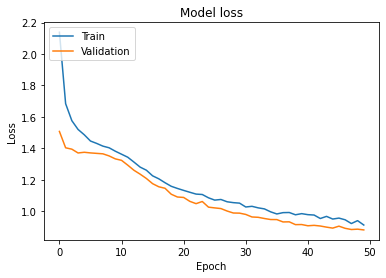

Training Accuracy: 70.07092237472534
Test Accuracy: 61.85101866722107


In [81]:
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(cnn1, data=data, time_period=500, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### cnn2

In [90]:
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape, AveragePooling1D

# cnn2 from cheng-tse 62%
# def cnn2(kernel_initializer, time_period):
#     model = Sequential()

#     model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
#     model.add(Conv2D(20, kernel_size=(1, 10)))
#     model.add(ELU())
#     model.add(Conv2D(20, kernel_size=(3, 3)))
#     model.add(ELU())
#     model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(20, kernel_size=(3, 3)))
#     model.add(ELU())
#     model.add(Conv2D(20, kernel_size=(3, 3)))
#     model.add(ELU())
#     model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
#     model.add(Dropout(0.1))

#     model.add(Conv2D(20, kernel_size=(3, 3)))
#     model.add(ELU())
#     model.add(Conv2D(20, kernel_size=(12, 1)))
#     model.add(ELU())
#     model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
#     model.add(Dropout(0.1))

#     model.add(Permute((2, 1, 3)))
#     model.add(Reshape((time_period-17, -1)))
#     model.add(AveragePooling1D(pool_size=78, strides=15))

#     model.add(Flatten())
#     model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

#     return model

def cnn2(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(20, kernel_size=(1, 10)))
    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(Conv2D(20, kernel_size=(12, 1)))
    model.add(ELU())
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(Dropout(0.1))

    model.add(Permute((2, 1, 3)))
    model.add(Reshape((time_period-15, -1)))
    model.add(AveragePooling1D(pool_size=78, strides=15))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

Epoch 1/50
51/51 [==============================] - 6s 101ms/step - loss: 3.2834 - categorical_accuracy: 0.4306 - val_loss: 1.7540 - val_categorical_accuracy: 0.5823
Epoch 2/50
51/51 [==============================] - 5s 93ms/step - loss: 1.5596 - categorical_accuracy: 0.5814 - val_loss: 1.2798 - val_categorical_accuracy: 0.6005
Epoch 3/50
51/51 [==============================] - 5s 93ms/step - loss: 1.2271 - categorical_accuracy: 0.6185 - val_loss: 1.1990 - val_categorical_accuracy: 0.6060
Epoch 4/50
51/51 [==============================] - 5s 93ms/step - loss: 1.1794 - categorical_accuracy: 0.6236 - val_loss: 1.1813 - val_categorical_accuracy: 0.6060
Epoch 5/50
51/51 [==============================] - 5s 93ms/step - loss: 1.1486 - categorical_accuracy: 0.6346 - val_loss: 1.1633 - val_categorical_accuracy: 0.6186
Epoch 6/50
51/51 [==============================] - 5s 93ms/step - loss: 1.1194 - categorical_accuracy: 0.6471 - val_loss: 1.1067 - val_categorical_accuracy: 0.6564
Epoch 7/5

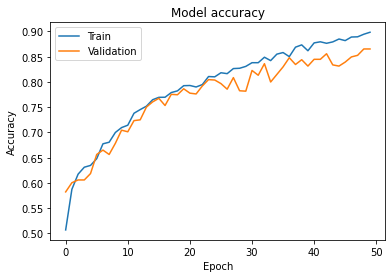

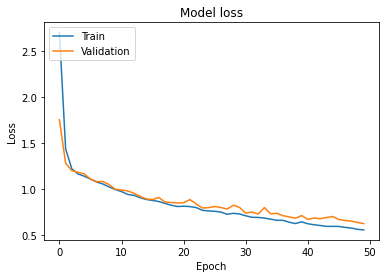

Training Accuracy: 91.36328101158142
Test Accuracy: 65.68848490715027


In [85]:
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, data=data, time_period=500, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### cnn3

In [15]:
# cnn3 from cheng-tse
def cnn3(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(20, kernel_size=(1, 10)))
    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(Conv2D(20, kernel_size=(12, 1)))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-05))
    model.add(ELU())

    model.add(Permute((2, 1, 3)))
    model.add(Reshape((time_period-17, -1)))
    model.add(AveragePooling1D(pool_size=78, strides=15))

    model.add(Flatten())
    model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

### cnn4

In [181]:
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape, AveragePooling1D

def cnn4(kernel_initializer, time_period):
    model = Sequential()

    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(20, kernel_size=(1, 10)))
    model.add(Conv2D(20, kernel_size=(3, 3)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(Dropout(0.1))

    model.add(Conv2D(16, kernel_size=(3, 3)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(Dropout(0.1))

    model.add(Conv2D(8, kernel_size=(3, 3)))
    model.add(Conv2D(8, kernel_size=(12, 1)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(Dropout(0.1))

    model.add(Permute((2, 1, 3)))
    model.add(Reshape((time_period-15, -1)))
    model.add(AveragePooling1D(pool_size=78, strides=15))

    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(4, kernel_regularizer=L1L2(0.01,0), activity_regularizer=L1L2(0,0.01), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

Epoch 1/50
51/51 [==============================] - 5s 83ms/step - loss: 1.5472 - categorical_accuracy: 0.3314 - val_loss: 1.3240 - val_categorical_accuracy: 0.5240
Epoch 2/50
51/51 [==============================] - 4s 78ms/step - loss: 1.2073 - categorical_accuracy: 0.5700 - val_loss: 1.0827 - val_categorical_accuracy: 0.6162
Epoch 3/50
51/51 [==============================] - 4s 79ms/step - loss: 1.0769 - categorical_accuracy: 0.6132 - val_loss: 1.0166 - val_categorical_accuracy: 0.6422
Epoch 4/50
51/51 [==============================] - 4s 79ms/step - loss: 0.9915 - categorical_accuracy: 0.6643 - val_loss: 0.9577 - val_categorical_accuracy: 0.6785
Epoch 5/50
51/51 [==============================] - 4s 79ms/step - loss: 0.9297 - categorical_accuracy: 0.6988 - val_loss: 0.9153 - val_categorical_accuracy: 0.6927
Epoch 6/50
51/51 [==============================] - 4s 79ms/step - loss: 0.8648 - categorical_accuracy: 0.7190 - val_loss: 0.8981 - val_categorical_accuracy: 0.6974
Epoch 7/50

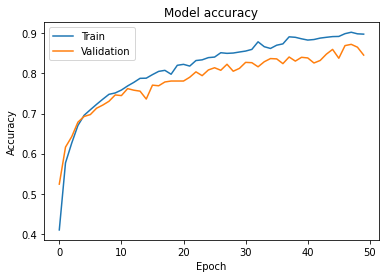

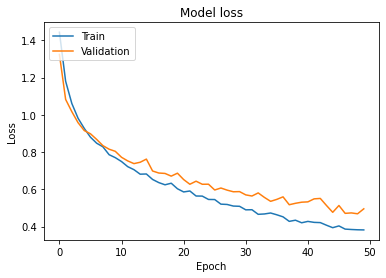

Training Accuracy: 91.6312038898468
Test Accuracy: 66.5914237499237


In [182]:
X_train_aug = np.concatenate((X_train_valid,X_train_gaussian,X_train_filtered), axis=0)
y_train_aug =  np.concatenate((y_train_valid,y_train_valid,y_train_valid), axis=0)

data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(cnn4, data=data, time_period=500, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Taixing

In [179]:
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape, AveragePooling1D
from keras.regularizers import L2

def cnn5(kernel_initializer, time_period):
    model = Sequential()
    
    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(29, kernel_size=(1, 4)))
    model.add(Conv2D(29, kernel_size=(22, 1)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(49, kernel_size=(1, 6)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(104, kernel_size=(1, 5)))
    model.add(BatchNormalization(axis=1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(4, activation='softmax', activity_regularizer=L2(0.1)))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

Epoch 1/150
53/53 [==============================] - 1s 16ms/step - loss: 2.1364 - categorical_accuracy: 0.2587 - val_loss: 1.7599 - val_categorical_accuracy: 0.3026
Epoch 2/150
53/53 [==============================] - 1s 10ms/step - loss: 1.8414 - categorical_accuracy: 0.3273 - val_loss: 1.6516 - val_categorical_accuracy: 0.3286
Epoch 3/150
53/53 [==============================] - 1s 10ms/step - loss: 1.6260 - categorical_accuracy: 0.3731 - val_loss: 1.5889 - val_categorical_accuracy: 0.3475
Epoch 4/150
53/53 [==============================] - 1s 10ms/step - loss: 1.5413 - categorical_accuracy: 0.3870 - val_loss: 1.4143 - val_categorical_accuracy: 0.3830
Epoch 5/150
53/53 [==============================] - 1s 10ms/step - loss: 1.3293 - categorical_accuracy: 0.4424 - val_loss: 1.3951 - val_categorical_accuracy: 0.3877
Epoch 6/150
53/53 [==============================] - 1s 10ms/step - loss: 1.2757 - categorical_accuracy: 0.4928 - val_loss: 1.3205 - val_categorical_accuracy: 0.4326
Epoc

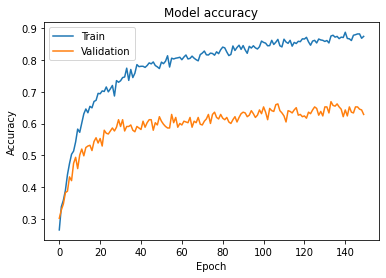

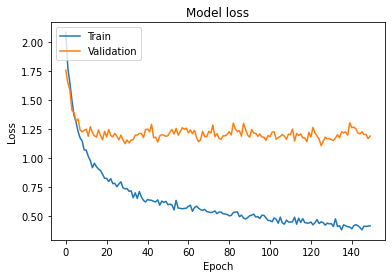

Training Accuracy: 91.96217656135559
Test Accuracy: 63.20541501045227


In [180]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn5, data=data, time_period=500, num_epoch=150, num_batch=32)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

###rnn1

In [16]:
###TA's example
from keras.layers import SimpleRNN
def rnn1(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()
    
    model.add(Permute((2, 1), input_shape=(22, time_period))) # (batch, 22, 1000) -> (batch, 1000, 22)
    model.add(SimpleRNN(hidden_dim)) # (batch, 1000, 22) -> (batch, hidden_dim)
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

### CNN+GRU

In [132]:
from keras.layers import Conv1D, MaxPool1D, GRU
from keras.optimizers import Adam
def CNN_GRU(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.35)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(GRU(50, kernel_regularizer=L1L2(0, 0.35), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

Epoch 1/50
51/51 [==============================] - 2s 16ms/step - loss: 20.3643 - categorical_accuracy: 0.3318 - val_loss: 7.3756 - val_categorical_accuracy: 0.4058
Epoch 2/50
51/51 [==============================] - 0s 8ms/step - loss: 6.1783 - categorical_accuracy: 0.4234 - val_loss: 3.6019 - val_categorical_accuracy: 0.4405
Epoch 3/50
51/51 [==============================] - 0s 8ms/step - loss: 3.1355 - categorical_accuracy: 0.4421 - val_loss: 2.1373 - val_categorical_accuracy: 0.4027
Epoch 4/50
51/51 [==============================] - 0s 8ms/step - loss: 1.9548 - categorical_accuracy: 0.4430 - val_loss: 1.6253 - val_categorical_accuracy: 0.4098
Epoch 5/50
51/51 [==============================] - 0s 8ms/step - loss: 1.5375 - categorical_accuracy: 0.4472 - val_loss: 1.4315 - val_categorical_accuracy: 0.4468
Epoch 6/50
51/51 [==============================] - 0s 8ms/step - loss: 1.4098 - categorical_accuracy: 0.4547 - val_loss: 1.3790 - val_categorical_accuracy: 0.4634
Epoch 7/50
51/

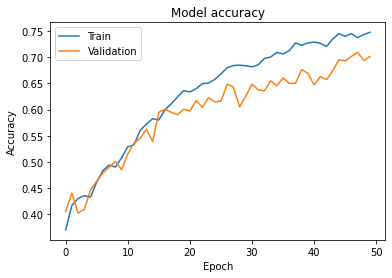

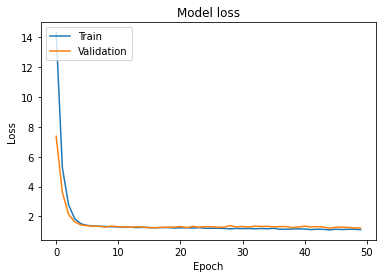

Training Accuracy: 78.34515571594238
Test Accuracy: 46.50112986564636


In [133]:
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(CNN_GRU, data=data, time_period=500, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### CNN+LSTM

In [88]:
from keras.layers import LSTM
from keras.optimizers import Adam
def CNN_LSTM(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.2)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(LSTM(hidden_dim, kernel_regularizer=L1L2(0, 0.2), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])

    return model

## Experiments

### Optimize for subject 1

In [ ]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, sub_idx=0, data=data, num_epoch=30)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize across all subjects

In [ ]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, data=data, time_period=400, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize as a function of time

Time Period = 200
Epoch 1/40
17/17 [==============================] - 16s 177ms/step - loss: 2.4870 - categorical_accuracy: 0.2830 - val_loss: 2.2685 - val_categorical_accuracy: 0.3712
Epoch 2/40
17/17 [==============================] - 1s 42ms/step - loss: 2.2391 - categorical_accuracy: 0.3792 - val_loss: 2.0871 - val_categorical_accuracy: 0.4374
Epoch 3/40
17/17 [==============================] - 1s 42ms/step - loss: 2.0663 - categorical_accuracy: 0.4491 - val_loss: 1.9502 - val_categorical_accuracy: 0.4232
Epoch 4/40
17/17 [==============================] - 1s 42ms/step - loss: 1.9047 - categorical_accuracy: 0.4740 - val_loss: 1.8303 - val_categorical_accuracy: 0.4799
Epoch 5/40
17/17 [==============================] - 1s 42ms/step - loss: 1.7822 - categorical_accuracy: 0.5010 - val_loss: 1.7363 - val_categorical_accuracy: 0.4823
Epoch 6/40
17/17 [==============================] - 1s 42ms/step - loss: 1.6858 - categorical_accuracy: 0.4983 - val_loss: 1.6345 - val_categorical_accurac

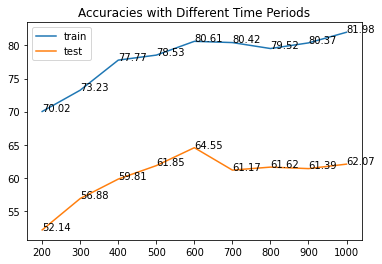

In [19]:
train_scores = []
test_scores = []
times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]

data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(cnn2, time_period=t, data=data, num_epoch=40, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")
for a, b, c in zip(times, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

Time Period = 200
Epoch 1/50
51/51 [==============================] - 5s 84ms/step - loss: 2.3558 - categorical_accuracy: 0.3496 - val_loss: 1.9725 - val_categorical_accuracy: 0.4326
Epoch 2/50
51/51 [==============================] - 2s 43ms/step - loss: 1.8345 - categorical_accuracy: 0.4779 - val_loss: 1.6061 - val_categorical_accuracy: 0.5043
Epoch 3/50
51/51 [==============================] - 2s 43ms/step - loss: 1.5184 - categorical_accuracy: 0.5355 - val_loss: 1.4104 - val_categorical_accuracy: 0.5083
Epoch 4/50
51/51 [==============================] - 2s 43ms/step - loss: 1.3378 - categorical_accuracy: 0.5469 - val_loss: 1.2994 - val_categorical_accuracy: 0.5185
Epoch 5/50
51/51 [==============================] - 2s 43ms/step - loss: 1.2786 - categorical_accuracy: 0.5271 - val_loss: 1.2479 - val_categorical_accuracy: 0.5382
Epoch 6/50
51/51 [==============================] - 2s 43ms/step - loss: 1.2127 - categorical_accuracy: 0.5497 - val_loss: 1.2142 - val_categorical_accuracy:

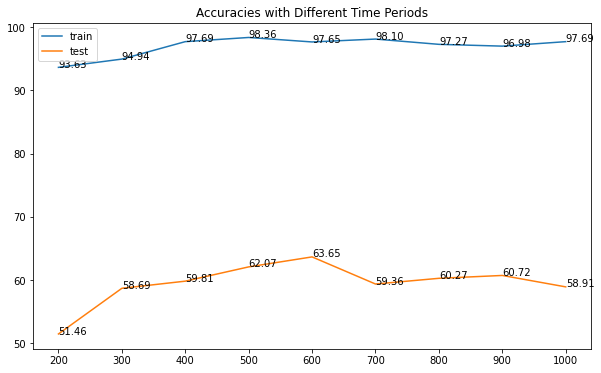

In [20]:
train_scores = []
test_scores = []
times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(cnn2, time_period=t, data=data, num_epoch=50, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.figure(figsize=(10,6))
plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")
for a, b, c in zip(times, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

### Compare Data Processing Technique

In [ ]:
data1 = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data1, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

data2 = {
    'X_train': X_train_gaussian,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data2, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)